In [3]:
# Cell 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Define all string variables for metrics
branch_misses = "Branch Misses"
branch_instructions = "Branch Instructions"
branch_miss_rate = "Branch Miss Rate"

cache_misses = "Cache Misses"
cache_references = "Cache References"
cache_miss_rate = "Cache Miss Rate"

executed_branch_mispredictions = "Executed Branch Mispredictions"
executed_branch_instructions = "Executed Branch Instructions"
executed_branch_misprediction_rate = "Executed Branch Misprediction Rate"

retired_branch_mispredictions = "Retired Branch Mispredictions"
retired_branch_instructions = "Retired Branch Instructions"
retired_branch_misprediction_rate = "Retired Branch Misprediction Rate"

executed_conditional_branch_mispredictions = "Executed Conditional Branch Mispredictions"
executed_conditional_branches = "Executed Conditional Branches"
executed_conditional_misprediction_rate = "Executed Conditional Misprediction Rate"

retired_near_taken_mispredictions = "Retired Near-Taken Branch Mispredictions"
retired_conditional_branches = "Retired Conditional Branches"
retired_near_taken_misprediction_rate = "Retired Near-Taken Misprediction Rate"

# Variables provided by you for L1, L2, and L3 cache metrics
L1_data_load_misses = "L1 Data Cache Load Misses"
L1_data_load_all = "L1 Data Cache Loads"
L1_data_load_miss_rate = "L1 Data Cache Load Miss Rate"

L2_demand_data_read_hits = "L2 Demand Data Read Hits"
L2_demand_data_read_all = "L2 All Demand Data Reads"
L2_demand_data_read_hit_rate = "L2 Demand Data Read Hit Ratio"

L3_demand_data_read_misses = "Offcore Demand Data Reads LLC Miss to DRAM"
L3_demand_data_read_hits = "Offcore Demand Data Reads LLC Hit Any Response"
L3_demand_data_read_miss_rate = "Offcore Demand Data Reads LLC Miss Rate"

L3_all_data_read_all = "Offcore All Data Reads LLC Any Response"
L3_all_data_read_misses = "Offcore All Data Reads LLC Miss to DRAM"
L3_all_data_read_miss_rate = "Offcore All Data Reads LLC miss rate"

# Define the rate pairs with meaningful names

rate_pairs = [
    (branch_misses, branch_instructions, branch_miss_rate),
    (cache_misses, cache_references, cache_miss_rate),
    (L1_data_load_misses, L1_data_load_all, L1_data_load_miss_rate),
    (L2_demand_data_read_hits, L2_demand_data_read_all, L2_demand_data_read_hit_rate),
    (L3_all_data_read_misses, L3_all_data_read_all, L3_all_data_read_miss_rate),
    (executed_branch_mispredictions, executed_branch_instructions, executed_branch_misprediction_rate),
    (retired_branch_mispredictions, retired_branch_instructions, retired_branch_misprediction_rate),
    (executed_conditional_branch_mispredictions, executed_conditional_branches, executed_conditional_misprediction_rate),
    (retired_near_taken_mispredictions, retired_conditional_branches, retired_near_taken_misprediction_rate),
    
]

def get_rate(df):
    """
    Compute logical rates from the given DataFrame based on predefined rate pairs.
    Returns a DataFrame with computed rates capped at 1 and infinities replaced with NaN.
    """
    rates_data = {}
    for numerator, denominator, rate_name in rate_pairs:
        rate = df[numerator] / df[denominator]
        rate.replace([float('inf'), -float('inf')], 0, inplace=True)  # Handle infinities
        rate = rate.clip(upper=1)  # Cap the rate at 1
        rates_data[rate_name] = rate
    
    rate = df[L3_demand_data_read_misses] / df[L3_demand_data_read_misses]+df[L3_demand_data_read_hits]
    rate = df[numerator] / df[denominator]
    rate.replace([float('inf'), -float('inf')], 0, inplace=True)  # Handle infinities
    rate.fillna(0, inplace=True)
    rate = rate.clip(upper=1)  # Cap the rate at 1
    rates_data[L3_demand_data_read_miss_rate] = rate
    
    return pd.DataFrame(rates_data)


In [5]:
# Cell 3: Load data and generate attack/idle rates

attack_file = "./../data/combined data files/Spectre/Spectre_20241118_122811.csv"
idle_file = "./../data/combined data files/Idle/Idle_20241118_122811.csv"

attack_data = pd.read_csv(attack_file)
idle_data = pd.read_csv(idle_file)

attack_rate = get_rate(attack_data.iloc[:500])
idle_rate = get_rate(idle_data.iloc[:500])


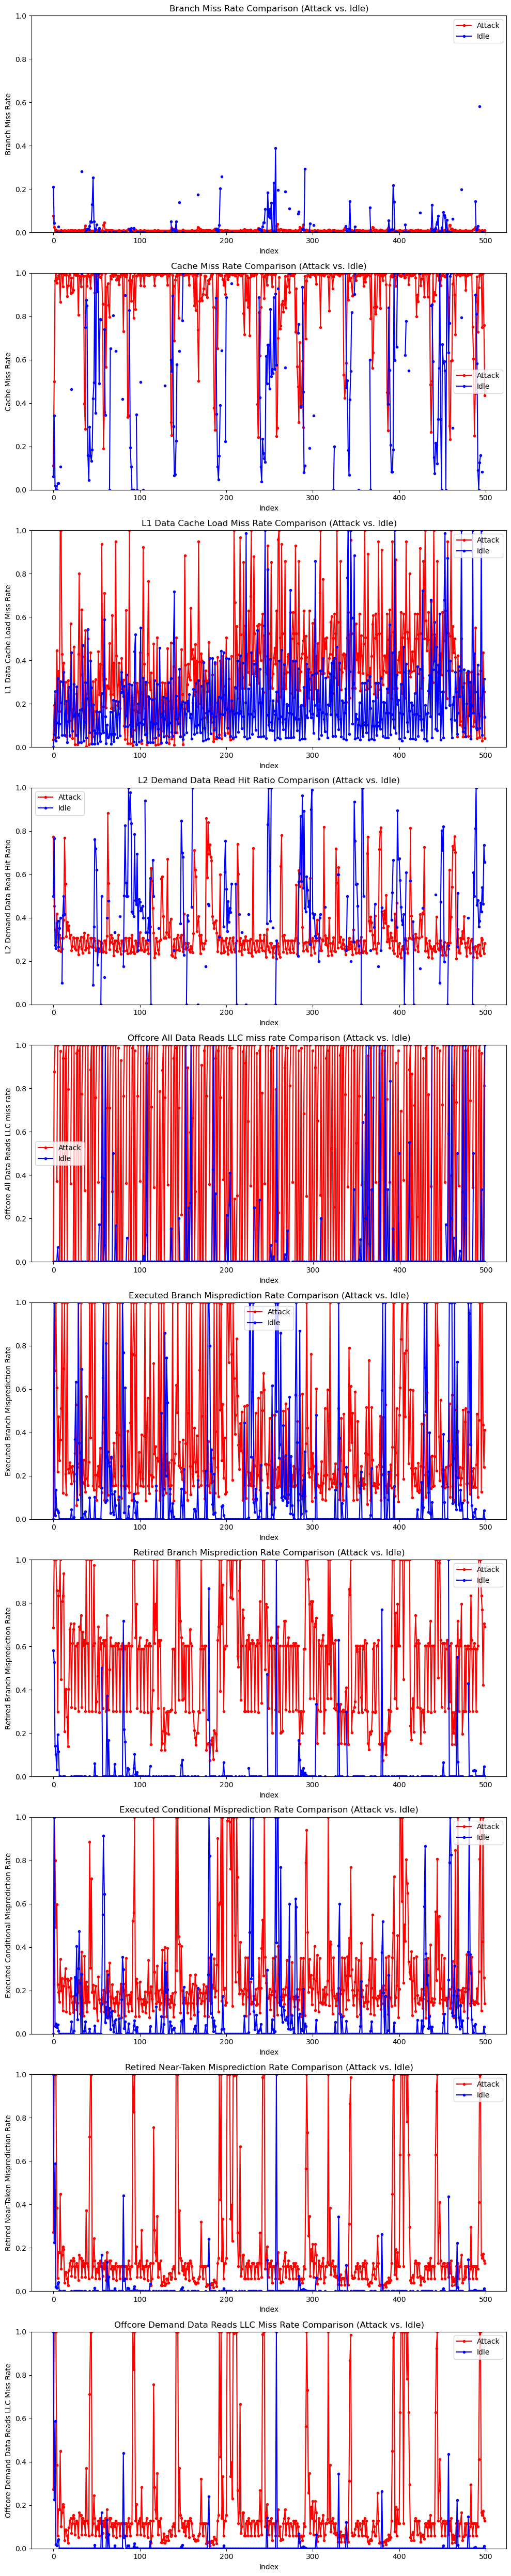

In [6]:
# Cell 4: Plot Attack vs. Idle Comparison (Line Plots)
fig, axes = plt.subplots(len(attack_rate.columns), 1, figsize=(10, 5 * len(attack_rate.columns)))

for i, column in enumerate(attack_rate.columns):
    ax = axes[i]
    ax.plot(attack_rate[column], label='Attack', marker='.', linestyle='-', color='red')
    ax.plot(idle_rate[column], label='Idle', marker='.', linestyle='-', color='blue')
    ax.set_title(f'{column} Comparison (Attack vs. Idle)')
    ax.set_xlabel('Index')
    ax.set_ylabel(column)
    ax.set_ylim(0, 1)
    ax.legend()

plt.tight_layout()
plt.show()


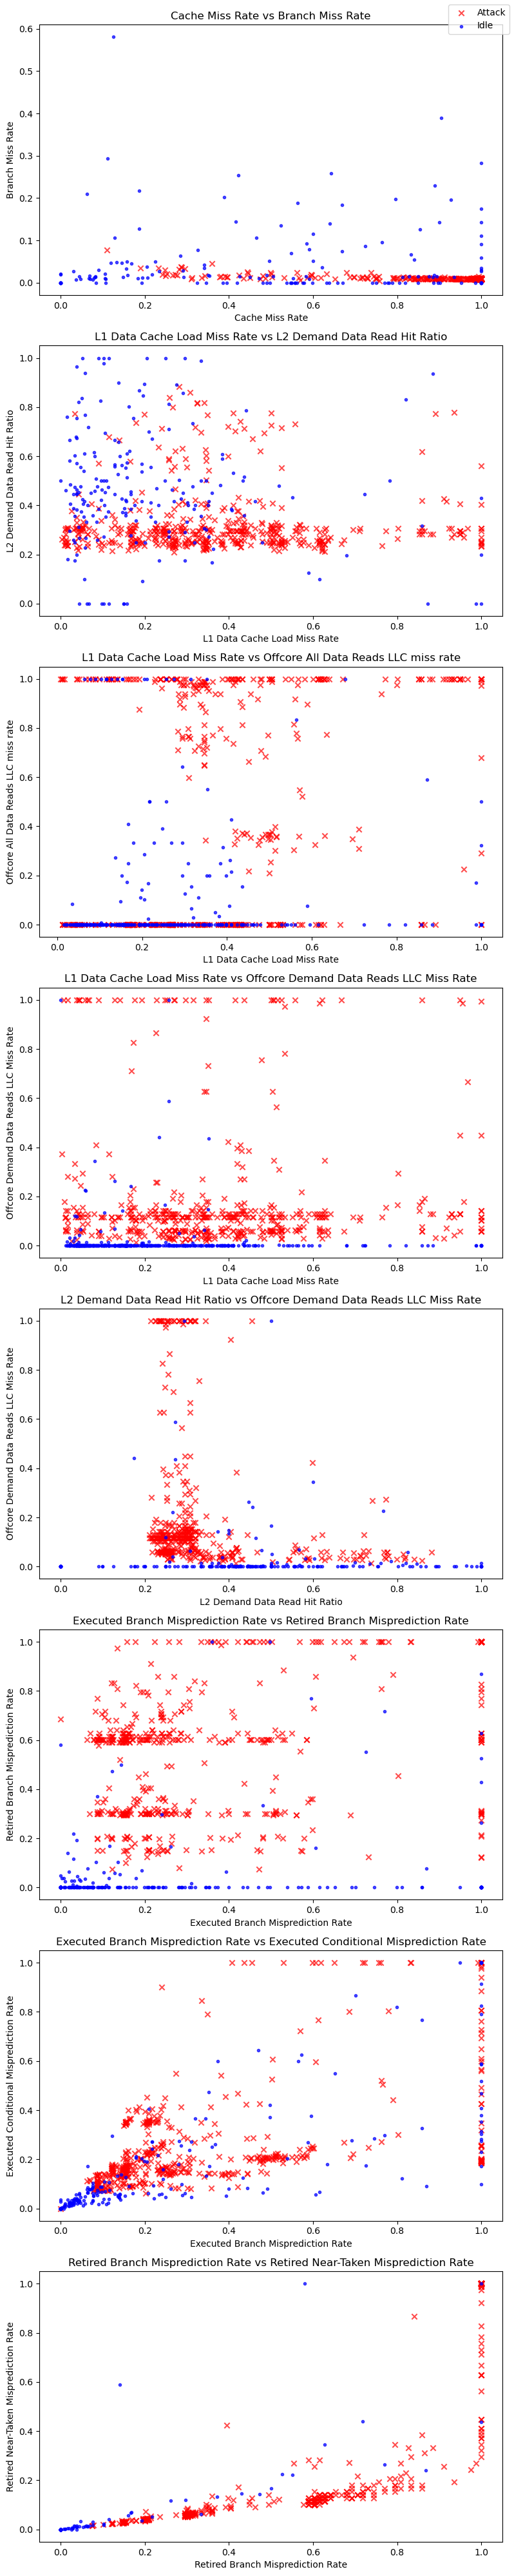

In [9]:
# Cell 5: Plot Cache vs Branch Metrics (Scatter Plots)
scatter_pairs = [
    (cache_miss_rate,branch_miss_rate),
    (L1_data_load_miss_rate, L2_demand_data_read_hit_rate),
    (L1_data_load_miss_rate,L3_all_data_read_miss_rate),
    (L1_data_load_miss_rate,L3_demand_data_read_miss_rate),
    (L2_demand_data_read_hit_rate,L3_demand_data_read_miss_rate),
    (executed_branch_misprediction_rate, retired_branch_misprediction_rate),
    (executed_branch_misprediction_rate, executed_conditional_misprediction_rate),
    (retired_branch_misprediction_rate, retired_near_taken_misprediction_rate)
]

fig, axes = plt.subplots(len(scatter_pairs), 1, figsize=(8, 5 * len(scatter_pairs)))
axes = axes.flatten()

plot_index = 0
for pair in scatter_pairs:
    ax = axes[plot_index]
    ax.scatter(attack_rate[pair[0]], attack_rate[pair[1]], color='red', marker='x', label='Attack', alpha=0.7)
    ax.scatter(idle_rate[pair[0]], idle_rate[pair[1]], color='blue', marker='.', label='Idle', alpha=0.7)
    ax.set_title(f'{pair[0]} vs {pair[1]}')
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    plot_index += 1

fig.legend(['Attack', 'Idle'], loc='upper right')
plt.tight_layout()
plt.show()